In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3  # Import InceptionV3
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import metrics
from keras.utils import to_categorical
import os

In [2]:
# Define the image size
SIZE = 256  

# Path to the dataset
dataset_path = "F:/indhu/Datasets/Tomato fruits dataset for binary and multiclass classification/Three Classes"
print(os.listdir(dataset_path))

['Reject', 'Ripe', 'Unripe']


In [3]:
# Capture images and labels into respective lists
images = []
labels = []
for directory_path in glob.glob(dataset_path + "/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        images.append(img)
        labels.append(label)

In [4]:
# Convert lists to arrays        
images = np.array(images)
labels = np.array(labels)

In [5]:
# Encode labels from text to integers
le = preprocessing.LabelEncoder()
labels_encoded = le.fit_transform(labels)

In [6]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)

In [7]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [8]:
# One hot encode y values for neural network (if needed later)
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [9]:
# Load InceptionV3 model without fully connected layers (pretrained on ImageNet)
Inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

In [10]:
# Use the pre-trained InceptionV3 model to extract features from training images
train_features = Inception_model.predict(x_train)
train_features = train_features.reshape(train_features.shape[0], -1)  # Flatten features for SVM

60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 519ms/step


In [11]:
# Train SVM on the extracted features
SVM_model = SVC(kernel='linear', random_state=42)
import time
start_train_time = time.time()
SVM_model.fit(train_features, y_train)
end_train_time = time.time()
# SVM doesn't need one-hot encoding, similar to RF

In [12]:
# Extract features from testing images
test_features = Inception_model.predict(x_test)
test_features = test_features.reshape(test_features.shape[0], -1)  # Flatten features for SVM


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 487ms/step


In [13]:
# Predict on test data using SVM
start_test_time = time.time()
y_pred = SVM_model.predict(test_features)
end_test_time = time.time()

In [14]:
# Inverse transform the predicted labels to their original form
y_pred_labels = le.inverse_transform(y_pred)

In [15]:
# Calculate time taken for training and testing
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

In [16]:
# Calculate accuracy of the model
accuracy = metrics.accuracy_score(le.inverse_transform(y_test), y_pred_labels)
print("Accuracy = ", accuracy)
print(f"Training time: {train_time} seconds")
print(f"Testing time: {test_time} seconds")

Accuracy =  0.925
Training time: 23.14661478996277 seconds
Testing time: 5.797818183898926 seconds


In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# Confusion matrix
cm = confusion_matrix(le.inverse_transform(y_test), y_pred_labels)

# Print the confusion matrix for reference
print(f"\nConfusion Matrix:\n{cm}")

# Precision, recall, and F1 score for each class
precision_per_class = precision_score(le.inverse_transform(y_test), y_pred_labels, average=None)
recall_per_class = recall_score(le.inverse_transform(y_test), y_pred_labels, average=None)
f1_per_class = f1_score(le.inverse_transform(y_test), y_pred_labels, average=None)

# For each class, calculate TP, FP, FN, TN
for i in range(len(cm)):
    tp = cm[i, i]  # True positives for class i
    fn = np.sum(cm[i, :]) - tp  # False negatives for class i
    fp = np.sum(cm[:, i]) - tp  # False positives for class i
    tn = np.sum(cm) - (tp + fp + fn)  # True negatives for class i
    
    print(f"\nClass {i}:\n\t")
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Negatives (TN): {tn}")
    
    # Print precision, recall, and F1 score for each class
    print(f"Precision: {precision_per_class[i]}")
    print(f"Recall: {recall_per_class[i]}")
    print(f"F1 Score: {f1_per_class[i]}")



Confusion Matrix:
[[139  17   4]
 [ 12 145   3]
 [  0   0 160]]

Class 0:
	
True Positives (TP): 139
False Positives (FP): 12
False Negatives (FN): 21
True Negatives (TN): 308
Precision: 0.9205298013245033
Recall: 0.86875
F1 Score: 0.8938906752411575

Class 1:
	
True Positives (TP): 145
False Positives (FP): 17
False Negatives (FN): 15
True Negatives (TN): 303
Precision: 0.8950617283950617
Recall: 0.90625
F1 Score: 0.9006211180124224

Class 2:
	
True Positives (TP): 160
False Positives (FP): 7
False Negatives (FN): 0
True Negatives (TN): 313
Precision: 0.9580838323353293
Recall: 1.0
F1 Score: 0.9785932721712538


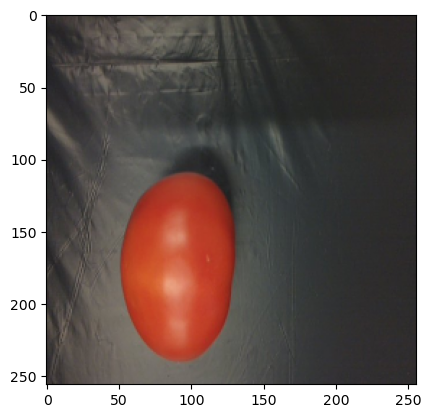

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
The prediction for this image is:  Ripe
The actual label for this image is:  Ripe


In [18]:
# Check results on a few select images
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
plt.show()

# Predict using SVM model for the selected image
input_img = np.expand_dims(img, axis=0)  # Expand dims so the input is (num images, x, y, c)
input_img_feature = Inception_model.predict(input_img)
input_img_feature = input_img_feature.reshape(input_img_feature.shape[0], -1)

prediction_SVM = SVM_model.predict(input_img_feature)[0]
prediction_SVM_label = le.inverse_transform([prediction_SVM])  # Reverse the label encoder to original name

print("The prediction for this image is: ", prediction_SVM_label[0])
print("The actual label for this image is: ", le.inverse_transform([y_test[n]])[0])
